## **ANN Model for Single Audio Event Detection**


In [ ]:
import numpy 
import os
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Initialize all path variables
dir_path = '/content/drive/MyDrive/Audio_Classification-MLSP'
train_data_path=os.path.join(dir_path, "train")

In [ ]:
# load data from 'annotations.csv' 
data=pd.read_csv(os.path.join(dir_path, "annotations.csv"))

### **Preprocessing data**

In [ ]:
#List containing all spectrograms
mel_spectrograms=[] 

for file in data['fname']:
  arr=numpy.load(os.path.join(train_data_path, file))
  m,n,o=arr.shape
  print(m, n, o)
  arr.resize(n,o)
  print(arr.shape)
  # Convert a power spectrogram (amplitude squared) to decibel (dB) units
  mel_spectrogram = librosa.power_to_db(arr, ref=numpy.max)
  # mfcc = librosa.features.mfcc(mel_spect)
  mel_spectrograms.append(mel_spectrogram)

1 128 314
(128, 314)
1 128 2504
(128, 2504)
1 128 236
(128, 236)
1 128 1070
(128, 1070)
1 128 272
(128, 272)
1 128 70
(128, 70)
1 128 664
(128, 664)
1 128 1421
(128, 1421)
1 128 432
(128, 432)
1 128 200
(128, 200)
1 128 1211
(128, 1211)
1 128 2512
(128, 2512)
1 128 52
(128, 52)
1 128 868
(128, 868)
1 128 106
(128, 106)
1 128 34
(128, 34)
1 128 2512
(128, 2512)
1 128 2584
(128, 2584)
1 128 72
(128, 72)
1 128 32
(128, 32)
1 128 44
(128, 44)
1 128 194
(128, 194)
1 128 100
(128, 100)
1 128 224
(128, 224)
1 128 1506
(128, 1506)
1 128 269
(128, 269)
1 128 518
(128, 518)
1 128 586
(128, 586)
1 128 100
(128, 100)
1 128 194
(128, 194)
1 128 41
(128, 41)
1 128 359
(128, 359)
1 128 282
(128, 282)
1 128 94
(128, 94)
1 128 314
(128, 314)
1 128 1701
(128, 1701)
1 128 240
(128, 240)
1 128 55
(128, 55)
1 128 2512
(128, 2512)
1 128 1114
(128, 1114)
1 128 230
(128, 230)
1 128 47
(128, 47)
1 128 272
(128, 272)
1 128 309
(128, 309)
1 128 259
(128, 259)
1 128 1512
(128, 1512)
1 128 2357
(128, 2357)
1 128 6

In [ ]:
# The data provided has constant frequency scale in spectrogram.
# But, the duration(time) is different for all the provided samples.
# Hence, it is necessary to pad the data

# get the max_length of spectrograms in the time axis
max_duration=0
for spec in mel_spectrograms:
  m,n=spec.shape
  if max_duration<n:
      max_duration=n

# add padding in the given .npy files
features=[]
for spec in mel_spectrograms:
  mat=numpy.pad(spec, [(0, 0), (0, max_duration-spec[0].size)], mode='constant', constant_values=0)
  mat=mat.reshape((mat.shape[0], mat.shape[1], 1))
  features.append(mat)

In [ ]:
# convert features list into numpy.ndarray type
features=numpy.array(features)

In [ ]:
data['label'].describe()

count     1000
unique      10
top       Bark
freq       100
Name: label, dtype: object

In [ ]:
# need to convert training data into tensor datatype
i=0
for _ in features:
    features[i]= tf.convert_to_tensor(features[i])
    i=i+1

### **Splitting Dataset into training and validation**

In [ ]:
X=features
y=data['label']

# used 'random_state' of 40 while splitting to get the balanced split of data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, shuffle="true")

In [ ]:
# get the count of classes present in y_test
print(type(y_test))
val_label=pd.Series(list(y_test))
val_label.value_counts()

<class 'pandas.core.series.Series'>


Bark                                     22
Walk_and_footsteps                       22
Doorbell                                 22
Crying_and_sobbing                       21
Siren                                    20
Knock                                    20
Vehicle_horn_and_car_horn_and_honking    20
Microwave_oven                           19
Shatter                                  17
Meow                                     17
dtype: int64

### **Convert label data (y_train & y_test) into 'one-hot vector' format**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

train_encoder = LabelEncoder()
train_ = train_encoder.fit_transform(y_train)
to_onehot=to_categorical(train_)
y_train=to_onehot

test_encoder = LabelEncoder()
test_ = test_encoder.fit_transform(y_test)
to_onehot=to_categorical(test_)
y_test=to_onehot

Definitions for recall, precision and f1 metrics

In [ ]:
# reference: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend 
from sklearn.metrics import precision_score , recall_score
def recall_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+backend.epsilon())) 

### **ANN Model**

In [ ]:
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = X_train.shape
num_classes = 10
print(X_train.shape)

(800, 128, 2584, 1)


In [ ]:
model = tf.keras.models.Sequential([
    #Fully connected 1st layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
]) 

In [ ]:
model.build(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (800, 330752)             0         
                                                                 
 dropout_1 (Dropout)         (800, 330752)             0         
                                                                 
 dense_3 (Dense)             (800, 128)                42336384  
                                                                 
 dense_4 (Dense)             (800, 128)                16512     
                                                                 
 dense_5 (Dense)             (800, 10)                 1290      
                                                                 
Total params: 42,354,186
Trainable params: 42,354,186
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile the model using Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
          loss=tf.keras.losses.CategoricalCrossentropy(),
          metrics=["accuracy", f1_m, precision_m, recall_m])

### **Training**

In [ ]:
# To keep track of the best metrices obtained while training the model
from keras.callbacks import ModelCheckpoint

filepath = '/content/drive/MyDrive/Audio_Classification-MLSP/my_best_model_ann.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=150, verbose = 1, callbacks=[checkpoint])

Epoch 1/150
13/13 [==============================] - ETA: 0s - loss: 56.5464 - accuracy: 0.1363 - f1_m: 0.1232 - precision_m: 0.1281 - recall_m: 0.1190
Epoch 1: val_loss improved from inf to 45.92176, saving model to /content/drive/MyDrive/Audio_Classification-MLSP/my_best_model_ann.hdf5
13/13 [==============================] - 4s 264ms/step - loss: 56.5464 - accuracy: 0.1363 - f1_m: 0.1232 - precision_m: 0.1281 - recall_m: 0.1190 - val_loss: 45.9218 - val_accuracy: 0.1400 - val_f1_m: 0.1916 - val_precision_m: 0.1918 - val_recall_m: 0.1914
Epoch 2/150
13/13 [==============================] - ETA: 0s - loss: 23.2767 - accuracy: 0.1863 - f1_m: 0.1788 - precision_m: 0.1897 - recall_m: 0.1695
Epoch 2: val_loss improved from 45.92176 to 22.31333, saving model to /content/drive/MyDrive/Audio_Classification-MLSP/my_best_model_ann.hdf5
13/13 [==============================] - 3s 233ms/step - loss: 23.2767 - accuracy: 0.1863 - f1_m: 0.1788 - precision_m: 0.1897 - recall_m: 0.1695 - val_loss: 22

### **Plots and Evaluation Metrices**

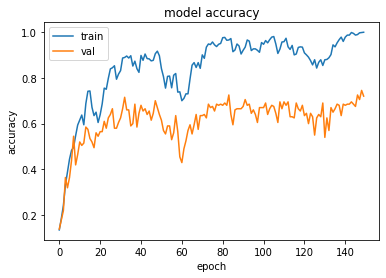

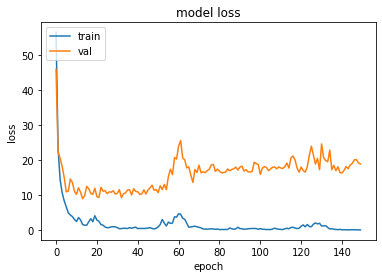

In [ ]:
from matplotlib import pyplot as plt
model.metrics_names
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Confusion matrix, heatmap and evalution metrics

In [ ]:
model = load_model(filepath, custom_objects={'f1_m':f1_m, 'precision_m':precision_m, 'recall_m':recall_m})

7/7 [==============================] - 0s 17ms/step - loss: 18.8571 - accuracy: 0.7200 - f1_m: 0.7102 - precision_m: 0.7206 - recall_m: 0.7009
n Test_Accuracy:- 0.7200000286102295
confusion matrix
[[16  0  2  0  2  1  0  0  0  1]
 [ 0 17  1  0  0  2  0  0  1  0]
 [ 1  0 17  0  0  3  1  0  0  0]
 [ 0  0  2 12  0  4  1  0  0  1]
 [ 0  2  0  0 14  0  0  0  0  1]
 [ 0  0  1  3  2 12  0  0  1  0]
 [ 1  1  0  1  1  1 11  0  0  1]
 [ 0  0  0  0  0  0  0 18  0  2]
 [ 0  1  2  1  0  0  0  0 16  0]
 [ 0  1  0  1  0  1  5  1  2 11]]


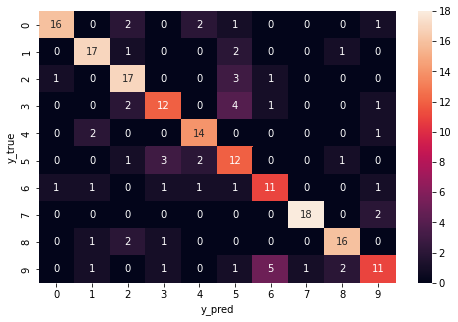

In [ ]:
accuracy = model.evaluate(X_test, y_test)
print('Validation-loss:', accuracy[0])
print('Accuracy:', accuracy[1])
print('F1 Score:', accuracy[2])
print('Precision:', accuracy[3])
print('Recall:', accuracy[4])
pred=model.predict(X_test)
y_pred = numpy.argmax(pred, axis=1)
y_true = numpy.argmax(y_test, axis=1)
print('confusion matrix')
print(confusion_matrix(y_true, y_pred))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()